In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [33]:
# Load the dataset
df = pd.read_csv("Mall_Customers.csv")
df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [34]:
# Only use relevant features
selected_df = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the features
scaler = StandardScaler()
scaled = scaler.fit_transform(selected_df)


In [35]:
best_score = -1
best_k = None

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(scaled)
    score = silhouette_score(scaled, preds)
    print(f"k={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\n✅ Best k: {best_k} with Silhouette Score: {best_score:.4f}")


k=2, Silhouette Score=0.3973
k=3, Silhouette Score=0.4666
k=4, Silhouette Score=0.4943
k=5, Silhouette Score=0.5547
k=6, Silhouette Score=0.5138
k=7, Silhouette Score=0.5020
k=8, Silhouette Score=0.4550
k=9, Silhouette Score=0.4567
k=10, Silhouette Score=0.4448

✅ Best k: 5 with Silhouette Score: 0.5547


In [51]:
import joblib
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Train and save KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(scaled)

# Train and save DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(scaled)

# Save models
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(dbscan, 'dbscan_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Calculate silhouette scores
kmeans_score = silhouette_score(scaled, kmeans.labels_)
# Only calculate DBSCAN score if at least 2 clusters exist (exclude noise)
dbscan_labels = dbscan.labels_
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
    dbscan_score = silhouette_score(scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_score = -1  # invalid or no meaningful clusters

# Save scores to a text file
with open("scores.txt", "w") as f:
    f.write(f"{kmeans_score}\n{dbscan_score}")


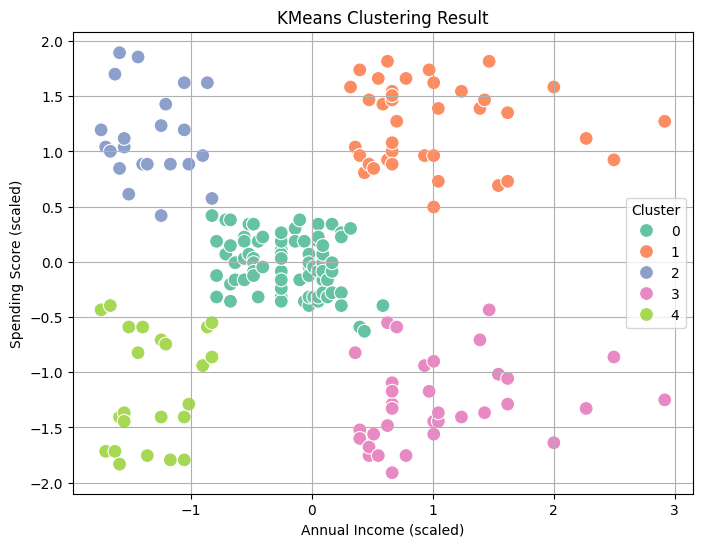

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add cluster labels to original DataFrame
df['KMeans_Cluster'] = kmeans.predict(scaled)

# Plot KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled[:, 0],
    y=scaled[:, 1],
    hue=df['KMeans_Cluster'],
    palette='Set2',
    s=100
)
plt.title("KMeans Clustering Result")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


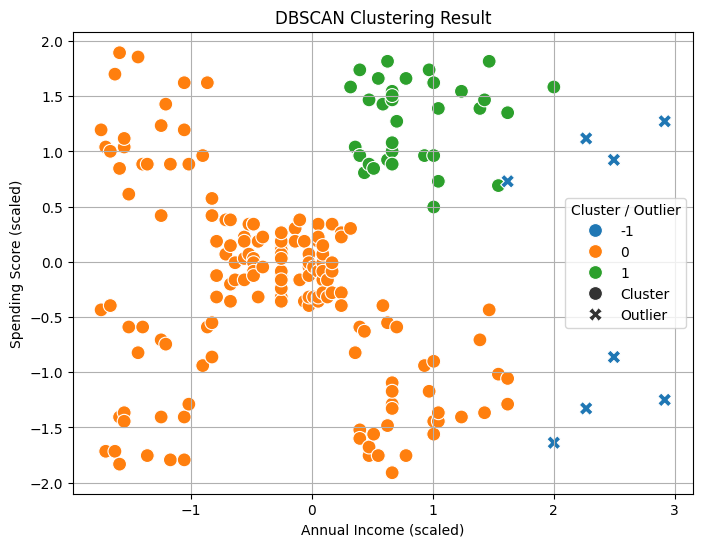

In [53]:
# Get DBSCAN cluster labels
dbscan_labels = dbscan.fit_predict(scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Plot DBSCAN clusters (including outliers)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled[:, 0],
    y=scaled[:, 1],
    hue=df['DBSCAN_Cluster'],
    palette='tab10',
    s=100,
    style=df['DBSCAN_Cluster'].apply(lambda x: "Outlier" if x == -1 else "Cluster")
)
plt.title("DBSCAN Clustering Result")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend(title="Cluster / Outlier")
plt.grid(True)
plt.show()


In [54]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import joblib

# Load models and scaler
kmeans = joblib.load('kmeans_model.pkl')
dbscan = joblib.load('dbscan_model.pkl')
scaler = joblib.load('scaler.pkl')

def predict_cluster():
    try:
        income = float(income_entry.get())
        score = float(score_entry.get())
        input_data = np.array([[income, score]])
        scaled_input = scaler.transform(input_data)

        # KMeans prediction
        kmeans_cluster = int(kmeans.predict(scaled_input)[0])

        # DBSCAN prediction
        dbscan_cluster = int(dbscan.fit_predict(scaled_input)[0])
        dbscan_label = "Outlier" if dbscan_cluster == -1 else f"Cluster {dbscan_cluster}"

        # Decide which prediction is better
        if dbscan_cluster == -1:
            best = "✅ KMeans is more confident (DBSCAN marked as Outlier)"
        else:
            best = "✅ Both models assigned a cluster.\nDBSCAN is more robust to outliers."

        result = (
            f"KMeans Cluster: {kmeans_cluster}\n"
            f"DBSCAN Cluster: {dbscan_label}\n\n"
            f"{best}"
        )

        messagebox.showinfo("Model Comparison Result", result)

    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter valid numbers.")
    except Exception as e:
        messagebox.showerror("Error", str(e))

# GUI Setup
root = tk.Tk()
root.title("Customer Cluster Predictor (KMeans vs DBSCAN)")

tk.Label(root, text="Annual Income (k$):").grid(row=0, column=0, padx=10, pady=10)
income_entry = tk.Entry(root)
income_entry.grid(row=0, column=1)

tk.Label(root, text="Spending Score (1-100):").grid(row=1, column=0, padx=10, pady=10)
score_entry = tk.Entry(root)
score_entry.grid(row=1, column=1)

tk.Button(root, text="Predict & Compare", command=predict_cluster, bg="#4CAF50", fg="white").grid(row=2, column=0, columnspan=2, pady=20)

root.mainloop()


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
